In [1]:
from msresist.clustering import MassSpecClustering
import pandas as pd
import numpy as np
from msresist.pre_processing import MeanCenter
from msresist.validations import pos_to_motif
from msresist.pca import plotPCA
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
import pickle
from msresist.figures.figure2 import plotDistanceToUpstreamKinase

Matplotlib is building the font cache; this may take a moment.


In [2]:
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
def add_motifs(X):
    X = MeanCenter(X, mc_row=True, mc_col=False)
    X.insert(1, "Position", [(aa + pos).split(";")[0] for aa, pos in zip(X["Amino Acid"], X["Positions Within Proteins"])])
    X = X.drop(["Amino Acid", "Positions Within Proteins"], axis=1)
    motifs, del_ids = pos_to_motif(X["Gene"], X["Position"])
    X = X.set_index(["Gene", "Position"]).drop(del_ids).reset_index()
    X.insert(0, "Sequence", motifs)
    return X


def centers(model, d, scale=True):
    centers = pd.DataFrame(model.transform()).T
    if scale:
        centers = pd.DataFrame(StandardScaler().fit_transform(centers))
    centers.columns = d.index
    centers.index = np.arange(model.ncl) + 1

    cols = centers.columns
    centers = centers.T
    centers["Cell Line"] = [i.split("_")[0] for i in cols]
    centers["Time point"] = [i.split("_")[1] for i in cols]
    return centers


def plot_cluster_centers_timepoints(ax, X, model, centers, cOI):
    cData = pd.melt(frame=centers, id_vars=["Cell Line", "Time point"], value_vars=centers.columns[:-2], value_name="Center", var_name="Cluster")
    X["Cluster"] = model.labels()
    for axI, lc in enumerate(cOI):
        dd = []
        for c in lc:
            cc = cData[cData["Cluster"] == c]
            cs = X[X["Cluster"] == c]
            cc["Cluster"] = [str(r) + " (n=" + str(cs.shape[0]) + ")" for r in cc["Cluster"]]
            dd.append(cc)
        cD = pd.concat(dd)
        sns.lineplot(data=cD, x="Time point", y="Center", style="Cluster", ax=ax[axI], color=["blue", "red", "green", "orange", "brown"][axI])
        ax[axI].set_title("Center Cluster ")

## 1. Calu Clustering

In [4]:
ms = pd.read_csv("msresist/data/MS/KRAS_G12C_Haura.csv")

# Calu
calu = add_motifs(ms.iloc[:, :6]).dropna()
dc = calu.select_dtypes(include=[float]).T
ic = calu.select_dtypes(include=[object])

In [5]:
with open("msresist/data/pickled_models/kras/KRAS_Haura_Calu_Binomial_CL15_W30", 'rb') as m:
    calu_model = pickle.load(m)
calu_centers = centers(calu_model, dc, scale=False)

No handles with labels found to put in legend.


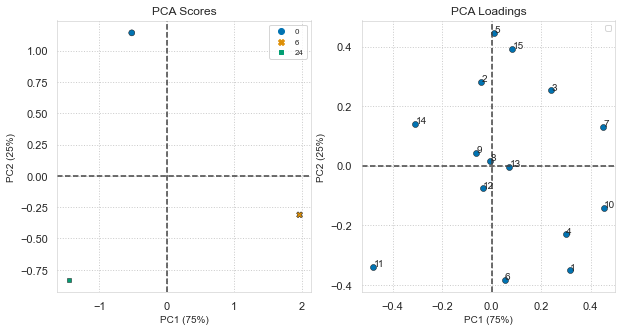

In [6]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, calu_centers.reset_index(), 2, ["Time point"], "Cluster", hue_scores="Time point", style_scores="Time point")
for i in range(2):
    ax[i].axhline(y=0, color="0.25", linestyle="--")
    ax[i].axvline(x=0, color="0.25", linestyle="--")

/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_57780/1672768734.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc["Cluster"] = [str(r) + " (n=" + str(cs.shape[0]) + ")" for r in cc["Cluster"]]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_57780/1672768734.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc["Cluster"] = [str(r) + " (n=" + str(cs.shape[0]) + ")" for r in cc["Cluster"]]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_57780/1672768734.py:33: Setting

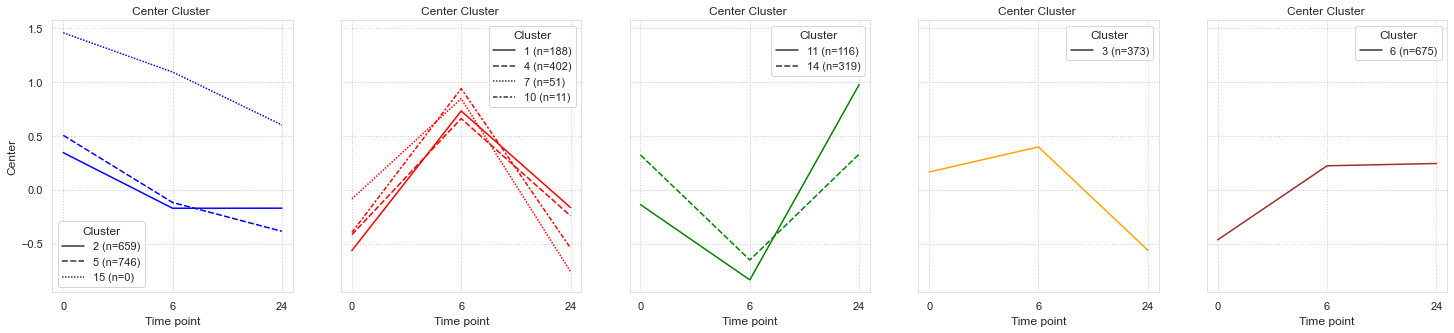

In [7]:
cOI = [[2, 5, 15], [1, 4, 7, 10], [11, 14], [3], [6]]

_, ax = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plot_cluster_centers_timepoints(ax, calu, calu_model, calu_centers, cOI)

/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub/resistance-MS/msresist/clustering.py:167: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub/resistance-MS/msresist/clustering.py:167: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


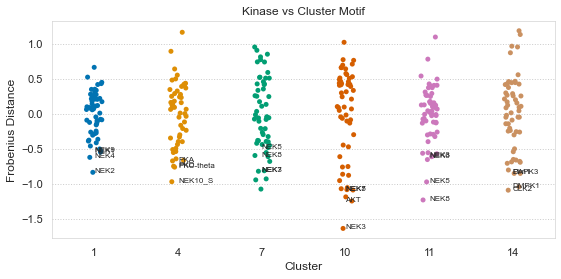

In [8]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))

cOI = [1, 4, 7, 10, 11, 14]
plotDistanceToUpstreamKinase(calu_model, cOI, ax, num_hits=4)

In [23]:
# Remove any clusters that is not in cOI
calu["Cluster"] = calu_model.labels()
drop = [8, 9, 12, 13]
for d in drop:
    calu = calu[calu["Cluster"] != d]

TODO:
- Manual review inside clusters
- If time , try tools of omics KRAS study

## 2. H1792 Clustering

In [45]:
with open("msresist/data/pickled_models/kras/KRAS_Haura_H1792_Binomial_CL15_W100", 'rb') as m:
    h1792_model = pickle.load(m)

In [37]:
h1792 = add_motifs(ms[list(ms.columns[:3]) + list(ms.columns[6:9])]).dropna()
dh = h1792.select_dtypes(include=[float]).T
ih = h1792.select_dtypes(include=[object])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


No handles with labels found to put in legend.


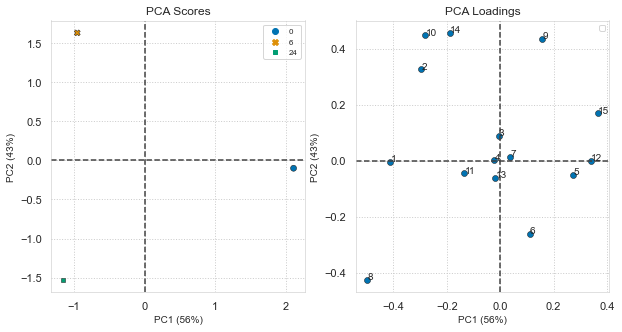

In [32]:
h1792_centers = centers(h1792_model, dh, scale=False)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, h1792_centers.reset_index(), 2, ["Time point"], "Cluster", hue_scores="Time point", style_scores="Time point")
for i in range(2):
    ax[i].axhline(y=0, color="0.25", linestyle="--")
    ax[i].axvline(x=0, color="0.25", linestyle="--")

/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_52546/1672768734.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc["Cluster"] = [str(r) + " (n=" + str(cs.shape[0]) + ")" for r in cc["Cluster"]]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_52546/1672768734.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc["Cluster"] = [str(r) + " (n=" + str(cs.shape[0]) + ")" for r in cc["Cluster"]]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_52546/1672768734.py:33: Setting

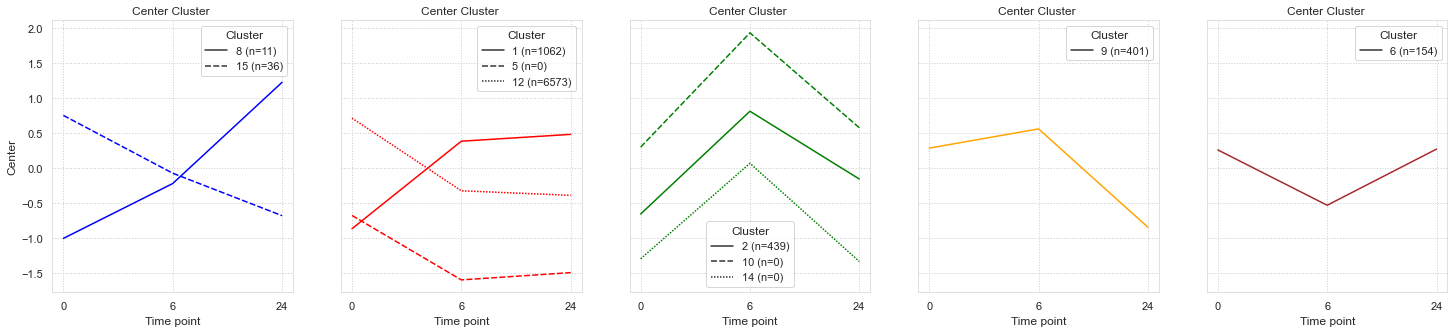

In [33]:
cOI = [[8, 15], [1, 5, 12], [2, 10, 14], [9], [6]]
_, ax = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plot_cluster_centers_timepoints(ax, h1792, h1792_model, h1792_centers, cOI)

In [41]:
# Remove any clusters that is not in cOI
h1792["Cluster"] = h1792_model.labels()
drop = [3, 4, 7, 11, 13]
for d in drop:
    h1792 = h1792[h1792["Cluster"] != d]

h1792.to_csv("h1792_clusters.csv")

/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub/resistance-MS/msresist/clustering.py:167: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub/resistance-MS/msresist/clustering.py:167: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)


AttributeError: 'list' object has no attribute 'iloc'

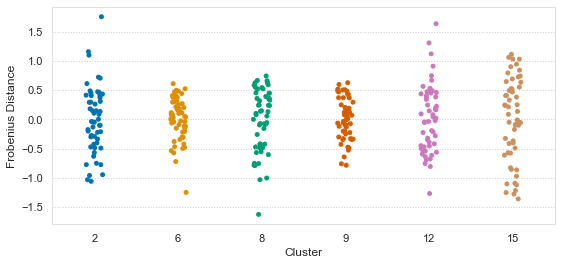

In [48]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))
plotDistanceToUpstreamKinase(h1792_model, [2, 6, 8, 9, 12, 15], ax, num_hits=4)